## 2-D modeling with GoFEM: a half-space example

This notebook shows how to setup a simple halfs-space model and parameter files for GoFEM

*Created by A. Grayver, 2019, Updated July 2024*

Let us start by including some common packages


In [17]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

Next, let the python know where deal.II's python package lives and also include pyGoFEM tools:

In [18]:
from gofem.parameter_handler import *
from gofem.mesh_utils import *
from gofem.data_utils import *

module_path = os.path.abspath('/home/ag/lib/dealii-9.5.2/build/lib/python3.12/site-packages')
if module_path not in sys.path:
    sys.path.append(module_path)

import PyDealII.Release as dealii

## Creating mesh and defining model properties

Create an initial coarse mesh.


In [19]:
dy = np.ones(shape=5) * 1e5
dz = np.array([100, 80, 60, 60, 80, 100], dtype = np.float64) * 1000
mesh_size = np.array([np.sum(dy), np.sum(dz)])

p_origin = dealii.Point((-mesh_size / 2.).tolist())
p_end = dealii.Point((mesh_size / 2.).tolist())

triangulation = dealii.Triangulation('2D')
triangulation.generate_subdivided_steps_hyper_rectangle([dy.tolist(), dz.tolist()], p_origin, p_end, False)

Now we can plot the mesh:

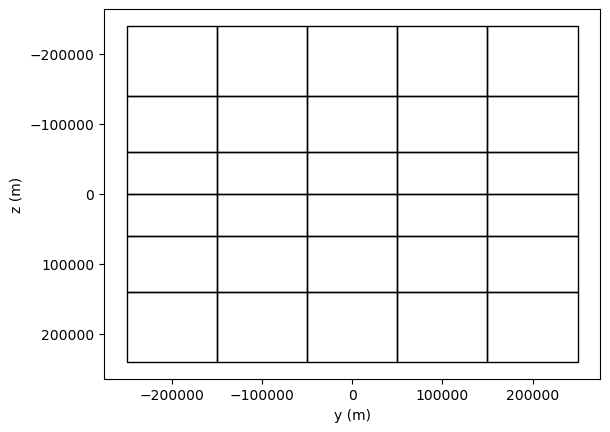

In [20]:
fig, ax = plot_2d_triangulation(triangulation)

This mesh is still rather coarse. Theory says, that in order to get an accurate solution, we need to refine at

* Conductivity contrasts
* Receiver locations

We can address this problem by refining the mesh globally several times:


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='y (m)', ylabel='z (m)'>)

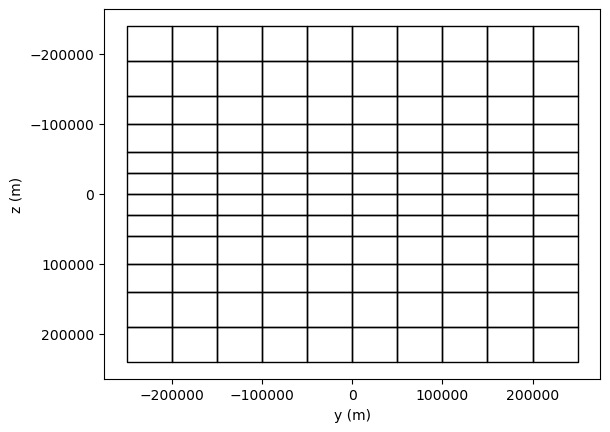

In [21]:
triangulation.refine_global(1)
plot_2d_triangulation(triangulation)

This is very inefficient, because each time we refine globally, number of cells is multiplied by four.

One of the most powerful features of GoFEM is locally refined meshes, which allow us to refine only in regions where it is needed. like at the air-ground interface. To do that, we first need to assign some physical properties to cells. We mark each cell with a material id. In particular, all cells above the ground are given material id one and the rest will have id two:

In [22]:
for cell in triangulation.active_cells():
    if cell.center().y < 0:
        cell.material_id = 1
    else:
        cell.material_id = 2



Note that in the deal.II notation, the two dimensional coordinate system is (X,Y) and we cannot change it at this stage.

However, the GoFEM convention is to use local NED coordinate system with Z pointing down, X pointing to the North and Y to the east. However, for 2D, the GoFEM takes X to be the strike direction, hence we are left with the (Y,Z) coordinate system. Therefore, we need to keep in mind that deal.II's (X,Y) system corresponds to the GoFEM's (Y,Z) system in 2D. GoFEM does this conversion internally, but here, for the mesh generation, we need to do it manually. This is the reason we invoke the Y coordinate of each cell's to check if the cell is in the air or under the surface.

We now need to actually assign some physical conductivity values (and names, for that matter) to the used id numbers. Let us simply use a python dictionary for that


In [23]:
materials = {1: ('air', 1e-8), 2: ('ground', 0.01)}

Additionally, we will set electric permittivity to zero everywhere. However, this can be changed is displacement currents are required.

In [24]:
# Switch to one if displacement currents are needed 
# (e.g., in case of RMT or GPR applications)
permittivity = 0.

Here, each material id is linked to a pair of values, representing its name and conductivity value (in S/m). This allows us to plot the mesh with conductivity assigned to each cell

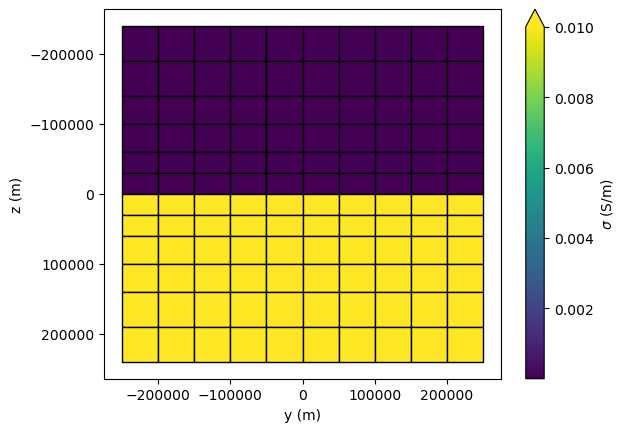

In [25]:
def color(cell):
    return materials[cell.material_id][1]

fig, ax = plot_2d_triangulation(triangulation, color_scheme=color)
fig.colorbar(ax.collections[0], ax=ax,\
             orientation = 'vertical',\
             label = r'$\sigma$ (S/m)',\
             norm=colors.LogNorm(vmin = 1e-8, vmax = 1e-2),\
             extend='max')

Finally, we can call a convenience function to refine at the air-ground interface

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='y (m)', ylabel='z (m)'>)

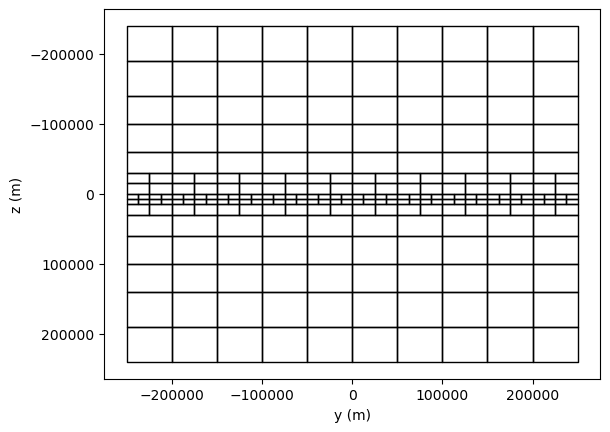

In [26]:
refine_at_interface(triangulation, material_ids = [2], repeat = 2)
plot_2d_triangulation(triangulation)

In this case, we did it twice and we excluded the air itself from refinement since accuracy in the air is less important. We can further refine only the central part since our receivers will be placed there

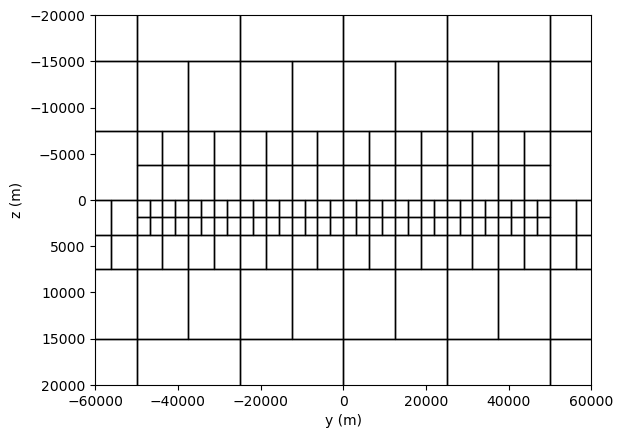

In [27]:
refine_at_interface(triangulation, material_ids = [2], repeat = 2, center = [0,0], radii = [50000])
fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-60000, 60000])
ax.set_ylim([-20000, 20000])
ax.invert_yaxis()

Let us see how many cells we have now and what is the diameter of the smallest and largest cells

In [28]:
print('# of cells = %d\nsmallest cell = %0.1f m\nlargest cell = %0.1f m' % (triangulation.n_active_cells(),\
                                                                      triangulation.minimal_cell_diameter(),\
                                                                      triangulation.maximal_cell_diameter()))

# of cells = 360
smallest cell = 3644.3 m
largest cell = 70710.7 m


This is still very modest number of cells, but we are getting there. Now, we can place some receivers at the surface and refine around these points. Again, we can use a convenience function from pyGoFEM and exclude air:

# of cells = 2904
smallest cell = 227.8 m
largest cell = 70710.7 m


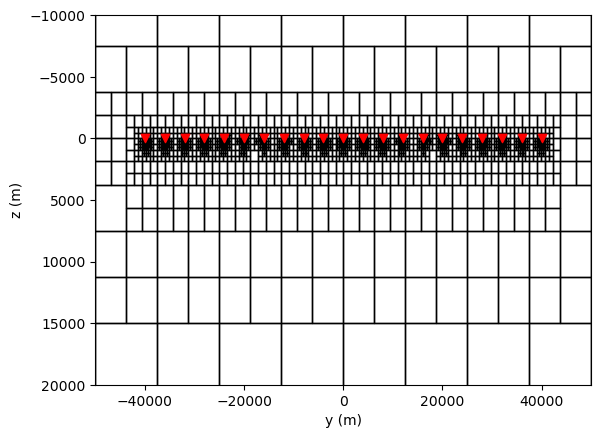

In [29]:
r_y = np.arange(-40000.1, 40000, 4000)
receivers = []
for y in r_y:
    receivers.append([y, 0.1])
    
refine_around_points(triangulation, points = receivers,\
                     center = [0, 0], radii = [2000, 2000],\
                     repeat = 2, exclude_materials = [1])

refine_around_points(triangulation, points = receivers,\
                     center = [0, 0], radii = [1000, 1000],\
                     repeat = 2, exclude_materials = [1])

fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-50000, 50000])
ax.set_ylim([-10000, 20000])
ax.invert_yaxis()
ax.scatter(r_y, r_y*0 + 0.1, color='r', marker='v')

print('# of cells = %d\nsmallest cell = %0.1f m\nlargest cell = %0.1f m' % (triangulation.n_active_cells(),\
                                                                      triangulation.minimal_cell_diameter(),\
                                                                      triangulation.maximal_cell_diameter()))

## Creating input files for GoFEM

Now, we can save the mesh, material properties and receivers in files that will be read by GoFEM:

In [30]:
# save the mesh
triangulation.save('./01/model.tria')

# save the material properties
with open('./01/model.materials', 'w') as f:
    f.write('# id name conductivity permitivitty\n')
    f.write('iso\n')
    for mid,properties in materials.items():
        f.write("%d %s %0.6e %0.6e\n" % (mid, properties[0], properties[1], permittivity))

# save receivers
with open('./01/receivers', 'w') as f:
    f.write('# type name number_of_points x y z\n')
    idx = 0
    for rec in receivers:
        f.write("Dipole R%d 1 0. %0.6e %0.6e\n" % (idx, rec[0], rec[1]))
        idx += 1
        
# save frequencies
frequencies = np.logspace(-2, 2, 33)
np.savetxt('./01/frequencies', frequencies, header = '# frequency (Hz)')

In case you work with CSEM, you have to also setup sources. Example below creates an inline unit current electric dipole source placed at (0,1):

In [31]:
with open('./01/sources', 'w') as f:
    f.write('# type name field n_parts x y z moment_x moment_y moment_z current_re current_im\n')
    f.write("Dipole S1 E 1 0. 0. 1. 0. 1. 0. 1. 0.\n")

Finally, we can create an input parameter file:

In [32]:
prm = ParameterHandler(inversion = False, dim = 2)

# Let's use quadratic elements for accuracy
prm.setitem(section = 'Modeling',\
            parameter = 'Order',\
            value = 2)

# Tell the code where to read all files from
prm.setitem(section = 'Model',\
            parameter = 'Model definition file',\
            value = '../model.tria')
prm.setitem(section = 'Model',\
            parameter = 'Materials definition file',\
            value = '../model.materials')

prm.setitem(section = 'Survey',\
            parameter = 'Frequencies file',
            value = '../frequencies')
prm.setitem(section = 'Survey',\
            parameter = 'Stations file',
            value = '../receivers')
prm.setitem(section = 'Survey',\
            parameter = 'Sources file',
            value = '../sources')

prm.setitem(section = 'Output',\
            parameter = 'Type',
            value = 'point')
prm.setitem(section = 'Output',\
            parameter = 'Data file',
            value = 'halfspace')

prm.write('./01/input_modeling.prm')

## Run the code

Since this is a simple 2-D problem, modeling will not take long and we can run it from here

In [35]:
import subprocess,shlex

f = open("output.txt", "w")
args = shlex.split("/home/ag/GoFEM/GOFEM/applications/emmod/build/Release/gofem --parameter_file ../input_modeling.prm --task modeling --dim 2 --method MT")
proc = subprocess.Popen(args, stdout=f, stderr=f, cwd = './01/results')
f.close()

## Reading and plotting results

Upon finishing, the GoFEM will output both the modelled fields at the receiver locations at all frequencies (and sources, for CSEM) as well as the VTU files with the model and its attributes (if this type of output is requested), such as conductivity, EM fields, etc. The former can be read using a pyGoFEM function, whereas the latter is a Paraview compatible format that you can visualize externally or, if you feel enthusiastic, you can also use the paraview from within the python. 

Below, we read the GoFEM modeling results at receivers by using the pandas:

In [41]:
import warnings
warnings.filterwarnings("ignore")

dfs = read_modeling_responses('./01/results/halfspace_c=0_f=%0.8e.txt', frequencies)

rho_data = np.zeros(shape=(len(frequencies),len(receivers),2))
phi_data = np.zeros(shape=(len(frequencies),len(receivers),2))
for idx in range(len(frequencies)):
    rho_data[idx] = dfs[idx][['rho_xy', 'rho_yx']]
    phi_data[idx] = dfs[idx][['phi_xy', 'phi_yx']]

And finally plot TE and TM modes

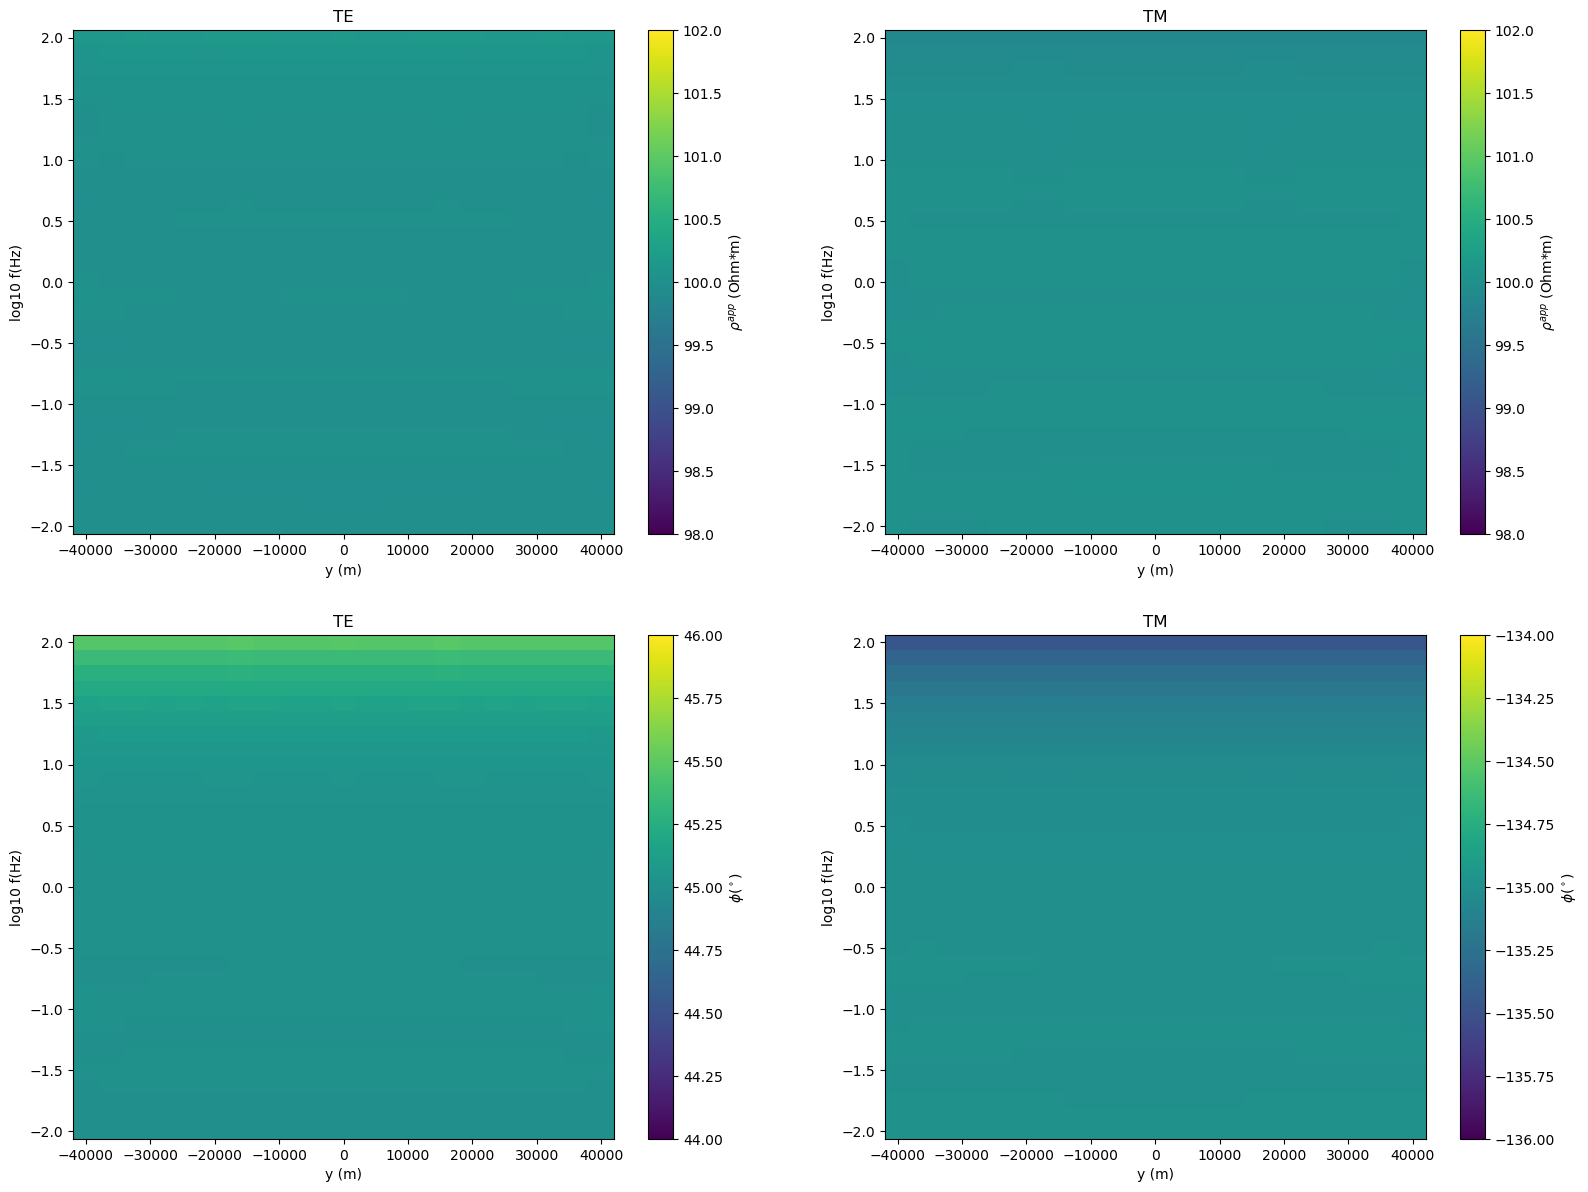

In [37]:
fig, axes = plt.subplots(2, 2)
p = axes[0,0].pcolormesh(r_y, np.log10(frequencies), rho_data[:,:,0], vmin=98, vmax = 102)
fig.colorbar(p, ax=axes[0,0], label=r'$\rho^{app}$ (Ohm*m)')
axes[0,0].set_title('TE'), axes[0,0].set_xlabel('y (m)'), axes[0,0].set_ylabel('log10 f(Hz)')
p = axes[0,1].pcolormesh(r_y, np.log10(frequencies), rho_data[:,:,1], vmin=98, vmax = 102)
fig.colorbar(p, ax=axes[0,1], label=r'$\rho^{app}$ (Ohm*m)')
axes[0,1].set_title('TM'), axes[0,1].set_xlabel('y (m)'), axes[0,1].set_ylabel('log10 f(Hz)')
p = axes[1,0].pcolormesh(r_y, np.log10(frequencies), phi_data[:,:,0], vmin=44, vmax = 46)
fig.colorbar(p, ax=axes[1,0], label=r'$\phi (^\circ)$')
axes[1,0].set_title('TE'), axes[1,0].set_xlabel('y (m)'), axes[1,0].set_ylabel('log10 f(Hz)')
p = axes[1,1].pcolormesh(r_y, np.log10(frequencies), phi_data[:,:,1], vmin=-136, vmax = -134)
fig.colorbar(p, ax=axes[1,1], label=r'$\phi (^\circ)$')
axes[1,1].set_title('TM'), axes[1,1].set_xlabel('y (m)'), axes[1,1].set_ylabel('log10 f(Hz)')
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)

As is anticipated, they look pretty boring, but match analytical values very well, confirming high accuracy. Note also that for the high frequencies wee see slight deviations from the theoretical values (visible in the phase plots). This can be fixed by adding one more refinement around receivers. 